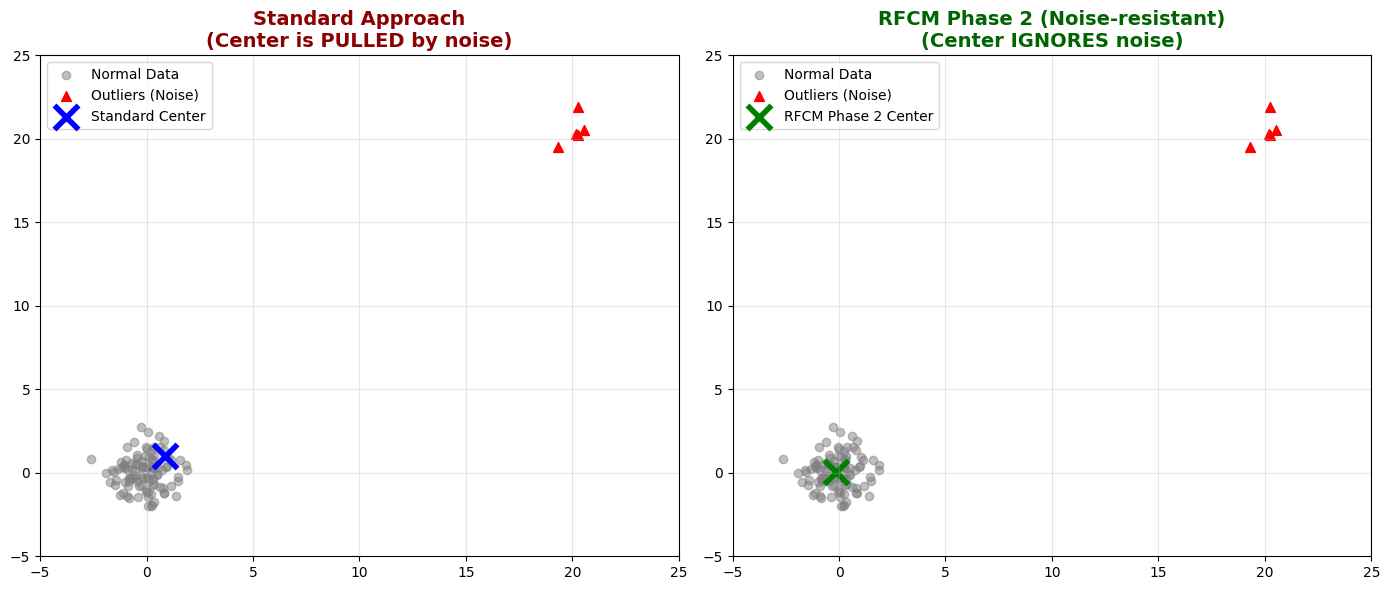

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_noisy_data():
    """
    生成含雜訊的測試數據
    - 主群聚: 100 個點聚集在 (0, 0)
    - 雜訊點: 5 個點在很遠的 (20, 20)
    """
    np.random.seed(42)
    
    # 正常流量：100 點聚集在 (0, 0)
    X_main = np.random.normal(loc=0, scale=1.0, size=(100, 2))
    
    # 雜訊/離群值：5 點在 (20, 20)
    # 雖然只有 5 點，但因為距離極遠，對傳統算法影響巨大
    X_noise = np.random.normal(loc=20, scale=0.5, size=(5, 2))
    
    X = np.vstack([X_main, X_noise])
    return X

def standard_mean_center(X):
    """
    模擬傳統算法 (如 K-Means/FCM)
    使用標準平均值，受歐氏距離影響，對離群值非常敏感
    """
    return np.mean(X, axis=0)

def noise_resistant_center(X, omega_sq=0.1):
    """
    模擬 RFCM 第二階段 (Noise-resistant)
    使用指數型權重衰減，距離越遠，權重越接近 0
    公式參考論文中的權重更新邏輯
    """
    # 1. 先隨機找個中心 (或是用受污染的平均值當起點)
    center = np.mean(X, axis=0) 
    
    # 迭代幾次讓它收斂 (模擬 RFCM 的迭代過程)
    for _ in range(10):
        # 計算每個點到中心的歐氏距離平方
        d_sq = np.sum((X - center) ** 2, axis=1)
        
        # --- 關鍵魔法 ---
        # 計算權重：f'(d^2) 正比於 exp(-omega^2 * d^2)
        # 距離 d 越大，exp 數值越小，權重趨近於 0
        weights = np.exp(-omega_sq * d_sq)
        
        # 更新中心點：加權平均
        center = np.sum(X * weights[:, None], axis=0) / np.sum(weights)
        
    return center

# --- 執行實驗 ---
X = generate_noisy_data()

# 1. 傳統算法結果
center_standard = standard_mean_center(X)

# 2. RFCM 抗雜訊結果
center_rfcm = noise_resistant_center(X, omega_sq=0.05)

# --- 繪圖 ---
plt.figure(figsize=(14, 6))

# 左圖：傳統算法
plt.subplot(1, 2, 1)
plt.scatter(X[:-5, 0], X[:-5, 1], c='gray', alpha=0.5, label='Normal Data')
plt.scatter(X[-5:, 0], X[-5:, 1], c='red', marker='^', s=50, label='Outliers (Noise)')
plt.scatter(center_standard[0], center_standard[1], c='blue', s=300, marker='x', linewidths=4, label='Standard Center')
# 畫一條線顯示被拉走的軌跡
plt.plot([0, center_standard[0]], [0, center_standard[1]], 'b--', alpha=0.3)
plt.title('Standard Approach\n(Center is PULLED by noise)', fontsize=14, fontweight='bold', color='darkred')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.grid(True, alpha=0.3)
plt.legend()

# 右圖：RFCM
plt.subplot(1, 2, 2)
plt.scatter(X[:-5, 0], X[:-5, 1], c='gray', alpha=0.5, label='Normal Data')
plt.scatter(X[-5:, 0], X[-5:, 1], c='red', marker='^', s=50, label='Outliers (Noise)')
plt.scatter(center_rfcm[0], center_rfcm[1], c='green', s=300, marker='x', linewidths=4, label='RFCM Phase 2 Center')
plt.title('RFCM Phase 2 (Noise-resistant)\n(Center IGNORES noise)', fontsize=14, fontweight='bold', color='darkgreen')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()